In [1]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true
import numpy as np
import pandas as pd
from keras.metrics import CategoricalAccuracy
from pandas import DataFrame
from keras.layers import TextVectorization
from sklearn.preprocessing import OneHotEncoder
import pickle
from keras.layers import Embedding, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Concatenate
from keras import initializers
from keras.utils import plot_model
from keras import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras_tuner import HyperParameters, RandomSearch
import keras

env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [2]:
olid = pd.read_csv("../data/olid-training-v1.0.tsv", sep="\t")
olid

id                                              tweet subtask_a  \
0      86426  @USER She should ask a few native Americans wh...       OFF   
1      90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2      16820  Amazon is investigating Chinese employees who ...       NOT   
3      62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4      43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   
...      ...                                                ...       ...   
13235  95338  @USER Sometimes I get strong vibes from people...       OFF   
13236  67210  Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...       NOT   
13237  82921  @USER And why report this garbage.  We don't g...       OFF   
13238  27429                                        @USER Pussy       OFF   
13239  46552  #Spanishrevenge vs. #justice #HumanRights and ...       NOT   

      subtask_b subtask_c  
0           UNT       NaN  
1           TIN       IND  
2           NaN       NaN  
3           UNT       NaN  
4           NaN       NaN  
...         ...       ...  
13235       TIN       IND  
13236       NaN       NaN  
13237       TIN       OTH  
13238       UNT       NaN  
13239       NaN       NaN  

[13240 rows x 5 columns]

In [3]:
train_data_a = olid['tweet']

lbl_train_a = olid['subtask_a']

In [4]:
train_data_b = []

lbl_train_b = []

for tweet, sb_b in zip(olid['tweet'], olid['subtask_b'].astype(str)):
    if sb_b != 'nan':
        train_data_b.append(tweet)
        lbl_train_b.append(sb_b)

In [6]:
train_data_c = []

lbl_train_c = []

for tweet, sb_c in zip(olid['tweet'], olid['subtask_c'].astype(str)):
    if sb_c != 'nan':
        train_data_c.append(tweet)
        lbl_train_c.append(sb_c)

# construction de la couche de vectorization

In [7]:
# int pour que les tokens soient représenter par des entiers plutôt que des vecteurs
vectorizer = TextVectorization(output_sequence_length=300, output_mode="int")
vectorizer.adapt(olid['tweet'],)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
vectorizer.vocabulary_size()

22418

# transformation des tweets en vecteurs d'entiers avec la méthode vectorizer

In [8]:
training_data_a = np.array(vectorizer(np.array(train_data_a)))
training_data_b = np.array(vectorizer(np.array(train_data_b)))
training_data_c = np.array(vectorizer(np.array(train_data_c)))

In [9]:
cat_to_int_a = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_a']))))}
label_train_a = np.array([cat_to_int_a[row] for row in lbl_train_a])

cat_to_int_a, label_train_a[:5]

({'NOT': 0, 'OFF': 1}, array([1, 1, 0, 1, 0]))

In [10]:
cat_to_int_b = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_b'].astype(str))))) if label != 'nan'}

In [11]:
label_train_b = []
for row in lbl_train_b:
    try :
        label_train_b.append(cat_to_int_b[row])
    except KeyError:
        continue

np.array(label_train_b).shape

(4400,)

In [12]:
cat_to_int_c = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_c'].astype(str))))) if label != 'nan'}

In [13]:
label_train_c = []

for row in lbl_train_c:
    try : 
        label_train_c.append(cat_to_int_c[row])
    except KeyError:
        continue
    
np.array(label_train_c).shape

(3876,)

# transformation des labels en one hot

In [14]:
ohe = OneHotEncoder()

y_train_ohe_a = ohe.fit_transform(np.array(label_train_a).reshape(-1,1)).toarray()

y_train_ohe_b = ohe.fit_transform(np.array(label_train_b).reshape(-1,1)).toarray()

y_train_ohe_c = ohe.fit_transform(np.array(label_train_c).reshape(-1,1)).toarray()


# chargement de la matrice d'embedding

In [15]:
embed_matrix = open("../data/embedding_matrix-1000.pickle", 'rb')
embed_matrix = pickle.load(embed_matrix)
embed_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.76435 ,  0.17534 ,  0.12309 , ...,  0.33769 , -0.059361,
        -0.11667 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

# construction du modèle tâche A

In [16]:
def build_model1(nb_filter=32,
                dropout=0.5,
                kernel=5,
                dense_units=64):
    # 1er modèle qui fera la classification de la première tâche

    int_sequences_input = Input(shape=(None,), dtype="int64", name="input")
    embedding = Embedding(
        len(embed_matrix), # nombre de tokens pris en charge pas la matrice
        len(embed_matrix[0]), # dimension des embedding de chaque mot
        embeddings_initializer=initializers.Constant(embed_matrix),
        trainable=True,
        input_length=300)(int_sequences_input)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_1a")(embedding)
    x = MaxPooling1D(5, name="max_pooling1d_1a")(x)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_2a")(x)
    x = MaxPooling1D(5, name="max_pooling1d_2a")(x)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_3a")(x)
    x = GlobalMaxPooling1D(name="glob_max_pooling_a")(x)
    first_dense = Dense(dense_units, activation="relu", name="classif_dense_a")(x)
    x = Dropout(dropout, name="dropout_a")(first_dense)
    preds_a = Dense(len(cat_to_int_a), activation="softmax", name="predict_task_a")(x)

    model1 = Model(inputs=[int_sequences_input], outputs=[preds_a], name='model1')

    model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=CategoricalAccuracy())

    print(plot_model(model1, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True))
    
    return model1

In [17]:
model1 = build_model1()

<IPython.core.display.Image object>


In [19]:
early_val_loss = EarlyStopping("val_loss", verbose=1)
early_val_acc_a = EarlyStopping("val_categorical_accuracy", verbose=1)

In [21]:
model1.fit(x=training_data_a, y=y_train_ohe_a, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_a])

Epoch 1/100
166/166 [==============================] - 24s 141ms/step - loss: 0.3456 - categorical_accuracy: 0.8599 - val_loss: 0.5107 - val_categorical_accuracy: 0.7696
Epoch 2/100
166/166 [==============================] - 22s 132ms/step - loss: 0.1610 - categorical_accuracy: 0.9451 - val_loss: 0.7063 - val_categorical_accuracy: 0.7625
Epoch 2: early stopping
Epoch 2: early stopping


In [22]:
test_olid_a = pd.read_csv("../data/testset-levela.tsv", sep="\t")
test_data_a = np.array(vectorizer(np.array(test_olid_a["tweet"])))
len(test_data_a)

860

In [23]:
res_test_a = model1.predict(test_data_a)

27/27 [==============================] - 0s 6ms/step


In [24]:
best_a = np.argmax(res_test_a, axis=1)
refs_a = pd.read_csv("../data/labels-levela.csv", header=None)

target = cat_to_int_a.keys()
print(classification_report(refs_a[1].map(lambda x: (cat_to_int_a[x])), best_a, target_names=target))

              precision    recall  f1-score   support

         NOT       0.82      0.90      0.86       620
         OFF       0.66      0.50      0.57       240

    accuracy                           0.79       860
   macro avg       0.74      0.70      0.71       860
weighted avg       0.78      0.79      0.78       860



## construction du modèle tâche B

In [25]:
def build_model2(nb_filter=32,
                dropout=0.5,
                kernel=5,
                dense_units=64):
    # 2ème modèle qui fera la classification de la deuxième tâche

    int_sequences_input = Input(shape=(None,), dtype="int64", name="input")
    embedding = Embedding(
        len(embed_matrix), # nombre de tokens pris en charge pas la matrice
        len(embed_matrix[0]), # dimension des embedding de chaque mot
        embeddings_initializer=initializers.Constant(embed_matrix),
        trainable=True,
        input_length=300)(int_sequences_input)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_1b")(embedding)
    x = MaxPooling1D(5, name="max_pooling1d_1b")(x)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_2b")(x)
    x = MaxPooling1D(5, name="max_pooling1d_2b")(x)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_3b")(x)
    x = GlobalMaxPooling1D(name="glob_max_pooling_b")(x)
    first_dense = Dense(dense_units, activation="relu", name="classif_dense_b")(x)
    x = Dropout(dropout, name="dropout_b")(first_dense)
    preds_b = Dense(len(cat_to_int_b), activation="softmax", name="predict_task_b")(x)

    model2 = Model(inputs=[int_sequences_input], outputs=[preds_b], name='model2')

    model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=CategoricalAccuracy())

    print(plot_model(model2, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True))
    
    return model2

In [26]:
early_val_acc_b = EarlyStopping("val_categorical_accuracy", verbose=1)

In [27]:
model2 = build_model2()

<IPython.core.display.Image object>


In [28]:
model2.fit(x=training_data_b, y=y_train_ohe_b, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_b])

Epoch 1/100
55/55 [==============================] - 8s 136ms/step - loss: 0.4168 - categorical_accuracy: 0.8668 - val_loss: 0.3554 - val_categorical_accuracy: 0.8830
Epoch 2/100
55/55 [==============================] - 7s 136ms/step - loss: 0.3607 - categorical_accuracy: 0.8804 - val_loss: 0.3512 - val_categorical_accuracy: 0.8830
Epoch 2: early stopping


In [29]:
test_olid_b = pd.read_csv("../data/testset-levelb.tsv", sep="\t")
test_data_b = np.array(vectorizer(np.array(test_olid_b["tweet"])))
len(test_data_b)

240

In [30]:
res_test_b = model2.predict(test_data_b)

8/8 [==============================] - 0s 6ms/step


In [31]:
best_b = np.argmax(res_test_b, axis=1)
refs_b = pd.read_csv("../data/labels-levelb.csv", header=None)

target = cat_to_int_b.keys()
print(classification_report(refs_b[1].map(lambda x: (cat_to_int_b[x])), best_b, target_names=target))

              precision    recall  f1-score   support

         TIN       0.89      1.00      0.94       213
         UNT       0.00      0.00      0.00        27

    accuracy                           0.89       240
   macro avg       0.44      0.50      0.47       240
weighted avg       0.79      0.89      0.83       240



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## construction modèle tâche C

In [32]:
def build_model3(nb_filter=32,
                dropout=0.5,
                kernel=5,
                dense_units=64):
    # 3ème modèle qui fera la classification de la troisième tâche

    int_sequences_input = Input(shape=(None,), dtype="int64", name="input")
    embedding = Embedding(
        len(embed_matrix), # nombre de tokens pris en charge pas la matrice
        len(embed_matrix[0]), # dimension des embedding de chaque mot
        embeddings_initializer=initializers.Constant(embed_matrix),
        trainable=True,
        input_length=300)(int_sequences_input)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_1c")(embedding)
    x = MaxPooling1D(5, name="max_pooling1d_1c")(x)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_2c")(x)
    x = MaxPooling1D(5, name="max_pooling1d_2c")(x)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_3c")(x)
    x = GlobalMaxPooling1D(name="glob_max_pooling_c")(x)
    first_dense = Dense(dense_units, activation="relu", name="classif_dense_c")(x)
    x = Dropout(dropout, name="dropout_c")(first_dense)
    preds_c = Dense(len(cat_to_int_c), activation="softmax", name="predict_task_c")(x)

    model3 = Model(inputs=[int_sequences_input], outputs=[preds_c], name='model3')

    model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=CategoricalAccuracy())

    print(plot_model(model3, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True))
    
    return model3

In [33]:
early_val_acc_c = EarlyStopping("val_categorical_accuracy", verbose=1)

In [34]:
model3 = build_model3()

<IPython.core.display.Image object>


In [35]:
model3.fit(x=training_data_c, y=y_train_ohe_c, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_c])

Epoch 1/100
49/49 [==============================] - 7s 138ms/step - loss: 0.9232 - categorical_accuracy: 0.6058 - val_loss: 0.8607 - val_categorical_accuracy: 0.6173
Epoch 2/100
49/49 [==============================] - 8s 160ms/step - loss: 0.8135 - categorical_accuracy: 0.6290 - val_loss: 0.8082 - val_categorical_accuracy: 0.6224
Epoch 3/100
49/49 [==============================] - 7s 135ms/step - loss: 0.6741 - categorical_accuracy: 0.7268 - val_loss: 0.7197 - val_categorical_accuracy: 0.7023
Epoch 4/100
49/49 [==============================] - 6s 123ms/step - loss: 0.4940 - categorical_accuracy: 0.8129 - val_loss: 0.7954 - val_categorical_accuracy: 0.6701
Epoch 4: early stopping
Epoch 4: early stopping


In [36]:
test_olid_c = pd.read_csv("../data/testset-levelc.tsv", sep="\t")
test_data_c = np.array(vectorizer(np.array(test_olid_c["tweet"])))
len(test_data_c)

213

In [37]:
res_test_c = model3.predict(test_data_c)

7/7 [==============================] - 0s 8ms/step


In [38]:
best_c = np.argmax(res_test_c, axis=1)
refs_c = pd.read_csv("../data/labels-levelc.csv", header=None)

target = cat_to_int_c.keys()
print(classification_report(refs_c[1].map(lambda x: (cat_to_int_c[x])), best_c, target_names=target))

              precision    recall  f1-score   support

         GRP       0.56      0.82      0.67        78
         IND       0.76      0.75      0.75       100
         OTH       0.00      0.00      0.00        35

    accuracy                           0.65       213
   macro avg       0.44      0.52      0.47       213
weighted avg       0.56      0.65      0.60       213



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## tuning des modèles

In [39]:
def hypermodel1(hp: HyperParameters) -> keras.Model:
    filters = hp.Choice('nb_filters',
                        values=[32, 64, 128, 256])
    
    dropout = hp.Float('dropout',
                        min_value=0.0, 
                        max_value=0.8, 
                        step=0.1)
    
    kernel = hp.Choice('kernel',
                        values=[3, 5])
    
    dense_units = hp.Choice('dense_unit',
                            values=[32, 64, 128, 256])
    
    return build_model1(nb_filter=filters, dropout=dropout, kernel=kernel, dense_units=dense_units)

In [40]:
def hypermodel2(hp: HyperParameters) -> keras.Model:
    filters = hp.Choice('nb_filters',
                        values=[32, 64, 128, 256])
    
    dropout = hp.Float('dropout',
                        min_value=0.0, 
                        max_value=0.8, 
                        step=0.1)
    
    kernel = hp.Choice('kernel',
                        values=[3, 5])
    
    dense_units = hp.Choice('dense_unit',
                            values=[32, 64, 128, 256])
    
    return build_model2(nb_filter=filters, dropout=dropout, kernel=kernel, dense_units=dense_units)

In [41]:
def hypermodel3(hp: HyperParameters) -> keras.Model:
    filters = hp.Choice('nb_filters',
                        values=[32, 64, 128, 256])
    
    dropout = hp.Float('dropout',
                        min_value=0.0, 
                        max_value=0.8, 
                        step=0.1)
    
    kernel = hp.Choice('kernel',
                        values=[3, 5])
    
    dense_units = hp.Choice('dense_unit',
                            values=[32, 64, 128, 256])
    
    return build_model3(nb_filter=filters, dropout=dropout, kernel=kernel, dense_units=dense_units)

In [49]:
tuner1 = RandomSearch(
    hypermodel=hypermodel1,
    objective=CategoricalAccuracy().name,
    max_trials=5,
    project_name="cnn-sep_tuning1"
)

INFO:tensorflow:Reloading Tuner from ./cnn-sep_tuning1/tuner0.json


In [50]:
tuner2 = RandomSearch(
    hypermodel=hypermodel2,
    objective=CategoricalAccuracy().name,
    max_trials=5,
    project_name="cnn-sep_tuning2"
)

<IPython.core.display.Image object>


In [51]:
tuner3 = RandomSearch(
    hypermodel=hypermodel3,
    objective=CategoricalAccuracy().name,
    max_trials=5,
    project_name="cnn-sep_tuning3"
)

<IPython.core.display.Image object>


In [52]:
tuner1.search(x=training_data_a, y=y_train_ohe_a, epochs=10, batch_size=64, validation_split=0.2)

Trial 7 Complete [00h 08m 57s]
categorical_accuracy: 0.9945241808891296

Best categorical_accuracy So Far: 0.9983950257301331
Total elapsed time: 00h 08m 57s
INFO:tensorflow:Oracle triggered exit


In [56]:
tuner2.search(x=training_data_b, y=y_train_ohe_b, epochs=10, batch_size=64, validation_split=0.2)

Trial 5 Complete [00h 01m 44s]
categorical_accuracy: 0.9980113506317139

Best categorical_accuracy So Far: 0.9982954263687134
Total elapsed time: 00h 07m 52s
INFO:tensorflow:Oracle triggered exit


In [57]:
tuner3.search(x=training_data_c, y=y_train_ohe_c, epochs=10, batch_size=64, validation_split=0.2)

Trial 5 Complete [00h 01m 48s]
categorical_accuracy: 0.9909677505493164

Best categorical_accuracy So Far: 0.9996774196624756
Total elapsed time: 00h 06m 16s
INFO:tensorflow:Oracle triggered exit


In [58]:
best_model1 = tuner1.get_best_models(1)[0]
best_model2 = tuner2.get_best_models(1)[0]
best_model3 = tuner3.get_best_models(1)[0]

<IPython.core.display.Image object>
<IPython.core.display.Image object>
<IPython.core.display.Image object>


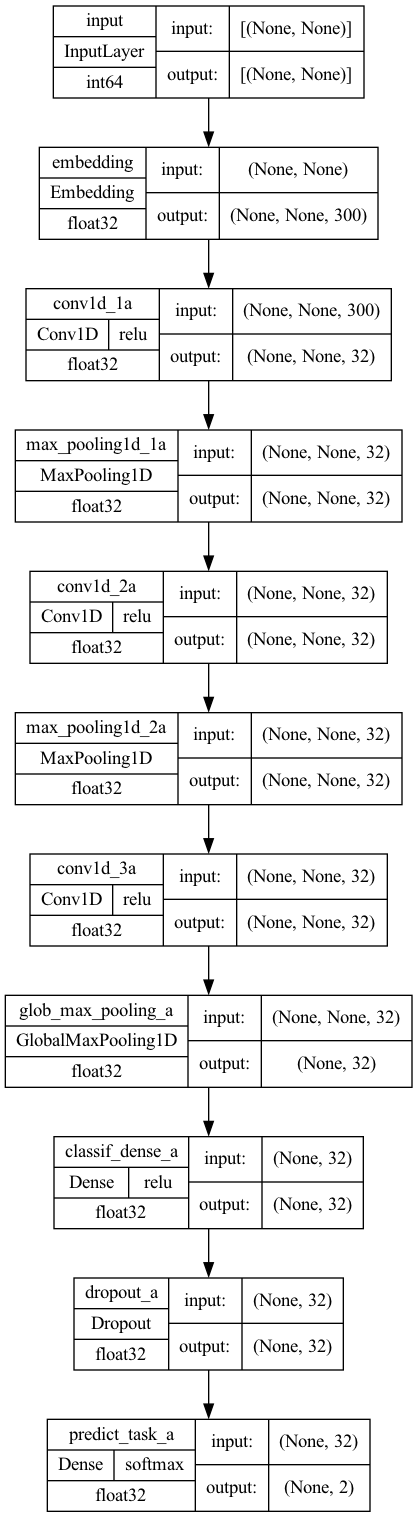

In [59]:
plot_model(best_model1, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
best_model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         33316200  
                                                                 
 conv1d_1a (Conv1D)          (None, None, 32)          28832     
                                                                 
 max_pooling1d_1a (MaxPoolin  (None, None, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_2a (Conv1D)          (None, None, 32)          3104      
                                                                 
 max_pooling1d_2a (MaxPoolin  (None, None, 32)         0         
 g1D)                                                       

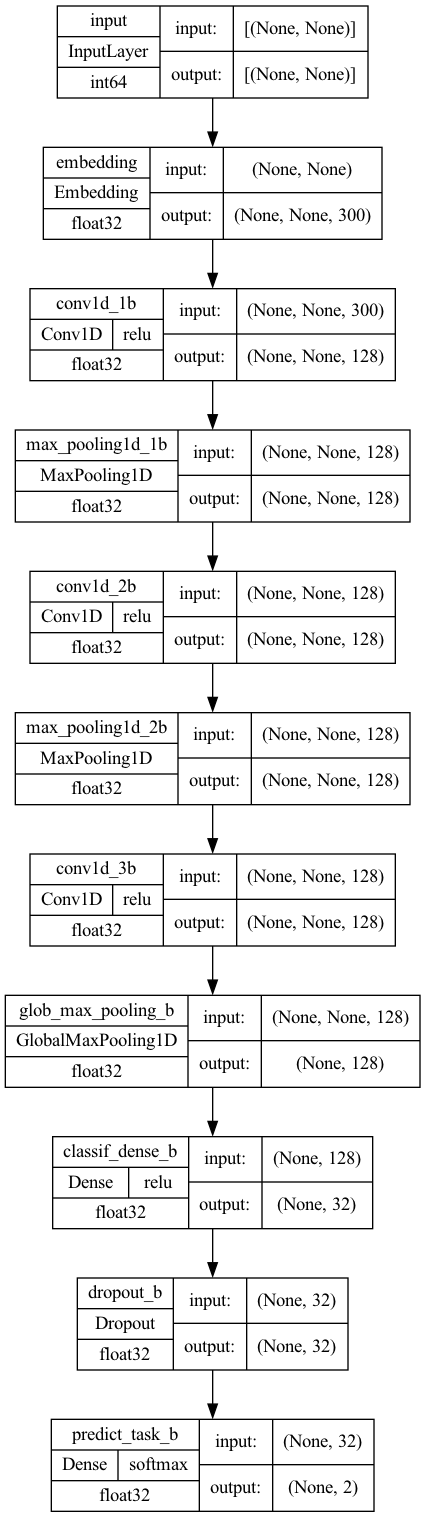

In [60]:
plot_model(best_model2, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [61]:
best_model2.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         33316200  
                                                                 
 conv1d_1b (Conv1D)          (None, None, 128)         115328    
                                                                 
 max_pooling1d_1b (MaxPooli  (None, None, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_2b (Conv1D)          (None, None, 128)         49280     
                                                                 
 max_pooling1d_2b (MaxPooli  (None, None, 128)         0         
 ng1D)                                                      

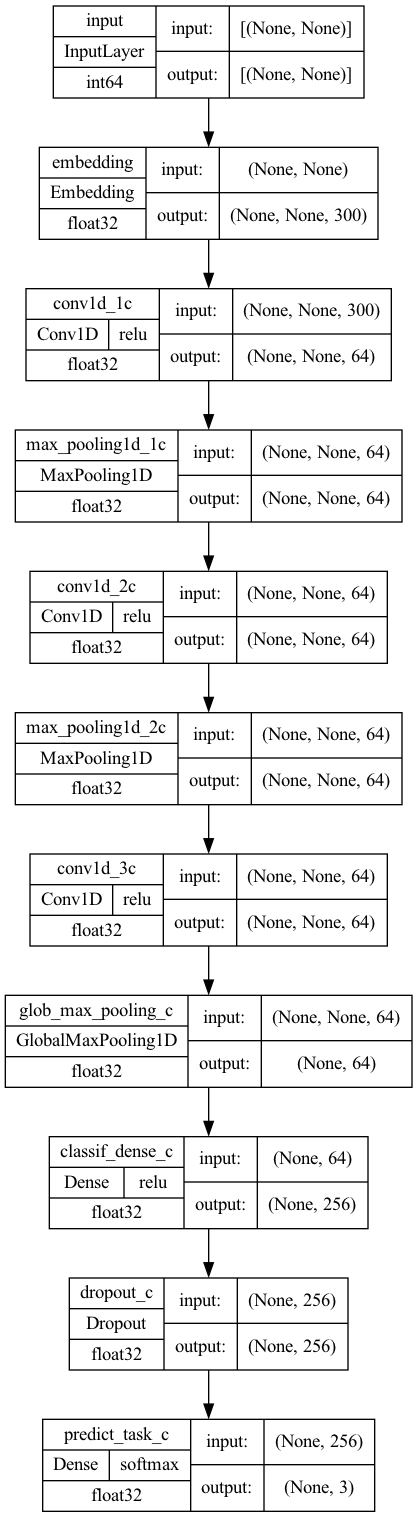

In [62]:
plot_model(best_model3, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [63]:
best_model3.summary()

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         33316200  
                                                                 
 conv1d_1c (Conv1D)          (None, None, 64)          57664     
                                                                 
 max_pooling1d_1c (MaxPooli  (None, None, 64)          0         
 ng1D)                                                           
                                                                 
 conv1d_2c (Conv1D)          (None, None, 64)          12352     
                                                                 
 max_pooling1d_2c (MaxPooli  (None, None, 64)          0         
 ng1D)                                                      

## test des modèles tunnés

In [64]:
res_test_a = best_model1.predict(test_data_a)

27/27 [==============================] - 0s 7ms/step


In [65]:
best_a = np.argmax(res_test_a, axis=1)
refs_a = pd.read_csv("../data/labels-levela.csv", header=None)

target = cat_to_int_a.keys()
print(classification_report(refs_a[1].map(lambda x: (cat_to_int_a[x])), best_a, target_names=target))

              precision    recall  f1-score   support

         NOT       0.87      0.76      0.81       620
         OFF       0.53      0.70      0.60       240

    accuracy                           0.74       860
   macro avg       0.70      0.73      0.70       860
weighted avg       0.77      0.74      0.75       860



In [68]:
res_test_b = best_model2.predict(test_data_b)

8/8 [==============================] - 0s 11ms/step


In [69]:
best_b = np.argmax(res_test_b, axis=1)
refs_b = pd.read_csv("../data/labels-levelb.csv", header=None)

target = cat_to_int_b.keys()
print(classification_report(refs_b[1].map(lambda x: (cat_to_int_b[x])), best_b, target_names=target))

              precision    recall  f1-score   support

         TIN       0.91      0.95      0.93       213
         UNT       0.41      0.26      0.32        27

    accuracy                           0.88       240
   macro avg       0.66      0.61      0.62       240
weighted avg       0.85      0.88      0.86       240



In [70]:
res_test_c = best_model3.predict(test_data_c)

7/7 [==============================] - 0s 7ms/step


In [71]:
best_c = np.argmax(res_test_c, axis=1)
refs_c = pd.read_csv("../data/labels-levelc.csv", header=None)

target = cat_to_int_c.keys()
print(classification_report(refs_c[1].map(lambda x: (cat_to_int_c[x])), best_c, target_names=target))

              precision    recall  f1-score   support

         GRP       0.69      0.62      0.65        78
         IND       0.75      0.82      0.78       100
         OTH       0.27      0.26      0.26        35

    accuracy                           0.65       213
   macro avg       0.57      0.56      0.56       213
weighted avg       0.65      0.65      0.65       213

